In [33]:
import os, math
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题

In [35]:
data = pd.read_csv('SH600519.csv')
data

,Unnamed: 0,date,open,close,high,low,volume,code
0,74,2010-04-26,88.702,87.381,89.072,87.362,107036.13,600519
1,75,2010-04-27,87.355,84.841,87.355,84.681,58234.48,600519
2,76,2010-04-28,84.235,84.318,85.128,83.597,26287.43,600519
3,77,2010-04-29,84.592,85.671,86.315,84.592,34501.20,600519
4,78,2010-04-30,83.871,82.340,83.871,81.523,85566.70,600519
...,...,...,...,...,...,...,...,...
2421,2495,2020-04-20,1221.000,1227.300,1231.500,1216.800,24239.00,600519
2422,2496,2020-04-21,1221.020,1200.000,1223.990,1193.000,29224.00,600519
2423,2497,2020-04-22,1206.000,1244.500,1249.500,1202.220,44035.00,600519
2424,2498,2020-04-23,1250.000,1252.260,1265.680,1247.770,26899.00,600519


In [37]:
# 划分训练集(前2126天)和测试集(后300天)
training_set = data.iloc[0:2426-300, 2:3].values # 只取开盘价
test_set = data.iloc[2426-300:, 2:3].values

In [39]:
# 归一化---缩放到0-1范围
sc = MinMaxScaler(feature_range=(0, 1))
training_set = sc.fit_transform(training_set) # fit()计算参数 transform转换训练集
test_set = sc.transform(test_set) # 用相同参数转换测试集

In [41]:
def create_dataset(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i, 0]) # 前60天的数据
        y.append(data[i, 0]) # 第61天的开盘价
    return np.array(X), np.array(y)
# 生成训练集和测试集
x_train, y_train = create_dataset(training_set)
x_test, y_test = create_dataset(test_set)
# 打乱训练集顺序
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

In [43]:
x_train = np.reshape(x_train, (x_train.shape[0], 60, 1)) # 样本数，时间步，特征数
x_test = np.reshape(x_test, (x_test.shape[0], 60, 1))

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(2066, 60, 1) (2066,) (240, 60, 1) (240,)


In [45]:
model = tf.keras.Sequential([
    SimpleRNN(80, return_sequences=True), # 返回完整序列 将每个时间步的隐藏状态传给下一层RNN
    Dropout(0.2),
    SimpleRNN(80), # 仅返回最后输出
    Dropout(0.2),
    Dense(1) # 预测收盘价
])

In [47]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')

In [49]:
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=20,
                    validation_data=(x_test, y_test),
                    validation_freq=1)

model.summary()

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0913 - val_loss: 0.0648
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0288 - val_loss: 0.0561
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0137 - val_loss: 0.0038
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0103 - val_loss: 0.0096
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0080 - val_loss: 0.0125
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0079 - val_loss: 0.0125
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0062 - val_loss: 0.0162
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0062 - val_loss: 0.0098
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0040 - val_loss: 0.0084
Epoch 11/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0046 - val_loss: 0.0151
Epoch 12/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 60, 80)         │         6,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 80)             │        12,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,565 (228.77 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 39,044 (152.52 KB)

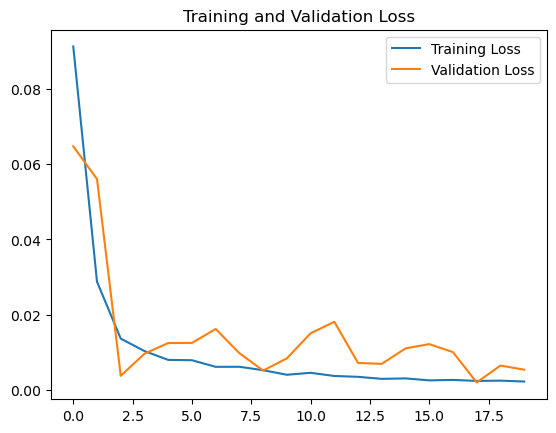

In [51]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


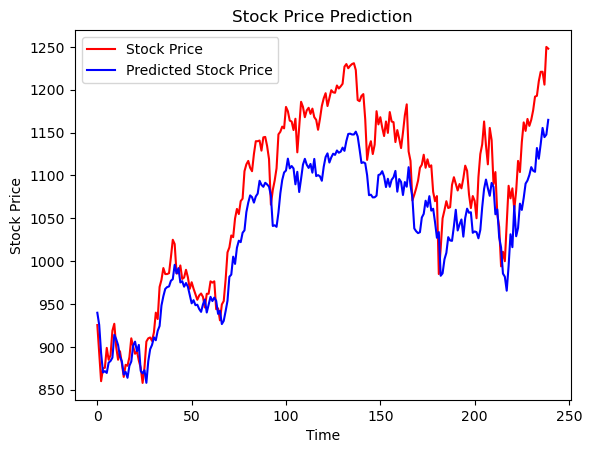

In [55]:
predicted_stock_price = model.predict(x_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
real_stock_price = sc.inverse_transform(test_set[60:])

plt.plot(real_stock_price, color='red', label='Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [57]:
MSE = metrics.mean_squared_error(predicted_stock_price, real_stock_price)
RMSE = metrics.mean_squared_error(predicted_stock_price, real_stock_price)**0.5
MAE = metrics.mean_absolute_error(predicted_stock_price, real_stock_price)
R2 = metrics.r2_score(predicted_stock_price, real_stock_price)

print('均方误差: %.5f' % MSE)
print('均方根误差: %.5f' % RMSE)
print('平均绝对误差: %.5f' % MAE)
print('R2: %.5f' % R2)

均方误差: 2710.27799
均方根误差: 52.06033
平均绝对误差: 44.76892
R2: 0.57580
